In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
df_nextbike = pd.read_csv("D:\\Seminar_Fahrrad\\download\\touren_Nextbike.csv")
print(df_nextbike.head())

   Unnamed: 0  FahrradID  AusleihstationID             AusleihstationName  \
0           0      42730                -1                      unbekannt   
1           1      42730            339475          Hauptbahnhof Mannheim   
2           2      42730            339343  Neckarstadt - Alter Messplatz   
3           3      42730            339466      G7 - Westliche Unterstadt   
4           4      42730         148606240   A1 - Landgericht/Universität   

   AusleihstationPLZ  AusleihzeitID  RueckgabestationID  \
0              60000         120145              339475   
1              68001         120195              339343   
2              68169         120235              339466   
3              68159         120725           148606240   
4              68002         120745              339472   

            RueckgabestationName  RueckgabestationPLZ  Rueckgabezeit  Dauer  \
0          Hauptbahnhof Mannheim              68001.0         120146      1   
1  Neckarstadt - Alter M

In [13]:
# --- Clean df_nextbike (short version) ---
df = df_nextbike.copy()
old_cols = df.columns.tolist()

# columns + missing values
df.columns = (df.columns.str.strip().str.lower()
              .str.replace(r"\s+", "_", regex=True)
              .str.replace(r"[^\w]", "", regex=True))
obj = df.select_dtypes(include="object")
df[obj.columns] = obj.apply(
    lambda s: s.astype(str).str.strip().replace(["", "-", "--", "na", "n/a", "null", "none", "nan"], pd.NA)
)

# datetime columns by name hint
for col in df.columns[df.columns.str.contains(r"date|time|datum|zeit", case=False, regex=True)]:
    dt = pd.to_datetime(df[col], errors="coerce", dayfirst=True)
    if dt.notna().mean() >= 0.5:
        df[col] = dt

# numeric-like object columns (comma decimal support)
for col in df.select_dtypes(include="object").columns:
    num = pd.to_numeric(df[col].str.replace(".", "", regex=False).str.replace(",", ".", regex=False), errors="coerce")
    if num.notna().mean() >= 0.7:
        df[col] = num

before = len(df)
df = df.dropna(how="all").drop_duplicates()
df_nextbike = df

print(f"Rows before: {before}")
print(f"Rows after:  {len(df_nextbike)}")
print(f"Rows removed: {before - len(df_nextbike)}")
print("\nColumn rename preview:")
print(dict(zip(old_cols, df_nextbike.columns)))
print("\nDataFrame info:")
df_nextbike.info()
print("\nHead:")
print(df_nextbike.head())

C:\Users\Radek\AppData\Local\Temp\ipykernel_43884\4031077759.py:16: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt = pd.to_datetime(df[col], errors="coerce", dayfirst=True)


Rows before: 381332
Rows after:  381332
Rows removed: 0

Column rename preview:
{'Unnamed: 0': 'unnamed_0', 'FahrradID': 'fahrradid', 'AusleihstationID': 'ausleihstationid', 'AusleihstationName': 'ausleihstationname', 'AusleihstationPLZ': 'ausleihstationplz', 'AusleihzeitID': 'ausleihzeitid', 'RueckgabestationID': 'rueckgabestationid', 'RueckgabestationName': 'rueckgabestationname', 'RueckgabestationPLZ': 'rueckgabestationplz', 'Rueckgabezeit': 'rueckgabezeit', 'Dauer': 'dauer', 'Rueckgabe_datetime': 'rueckgabe_datetime', 'Rueckgabe_Stunde': 'rueckgabe_stunde', 'Rueckgabe_Stunde_des_Tages': 'rueckgabe_stunde_des_tages', 'start_lat': 'start_lat', 'start_lon': 'start_lon', 'end_lat': 'end_lat', 'end_lon': 'end_lon', 'dist_km': 'dist_km'}

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381332 entries, 0 to 381331
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----      

In [14]:
from pathlib import Path

paths = [
    r"D:\Seminar_Fahrrad\download\stadtradeln_2022.xlsx",
    r"D:\Seminar_Fahrrad\download\stadtradeln_2023.xlsx",
    r"D:\Seminar_Fahrrad\download\stadtradeln_2024.xlsx",
    r"D:\Seminar_Fahrrad\download\Uebersicht_Dauerahrradzaehler_201403-202510_unvollstaendig.xlsx",
]

def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = (out.columns.astype(str).str.strip().str.lower()
                   .str.replace(r"\s+", "_", regex=True)
                   .str.replace(r"[^\w]", "", regex=True))
    obj = out.select_dtypes(include="object")
    if len(obj.columns):
        out[obj.columns] = obj.apply(lambda s: s.astype(str).str.strip().replace(["", "-", "--", "na", "n/a", "null", "none", "nan"], pd.NA))
    for c in out.columns[out.columns.str.contains(r"date|time|datum|zeit", case=False, regex=True)]:
        dt = pd.to_datetime(out[c], errors="coerce", dayfirst=True)
        if dt.notna().mean() >= 0.5:
            out[c] = dt
    for c in out.select_dtypes(include="object").columns:
        num = pd.to_numeric(out[c].str.replace(".", "", regex=False).str.replace(",", ".", regex=False), errors="coerce")
        if num.notna().mean() >= 0.7:
            out[c] = num
    return out.dropna(how="all").drop_duplicates()

cleaned = {}

for p in paths:
    ext = Path(p).suffix.lower()
    name = Path(p).name
    if ext in [".xlsx", ".xls"]:
        sheets = pd.read_excel(p, sheet_name=None)
        cleaned[name] = {s: clean_df(df) for s, df in sheets.items()}
        print(f"{name}: {len(cleaned[name])} Sheets bereinigt")
    elif ext == ".html":
        tables = pd.read_html(p)
        cleaned[name] = [clean_df(df) for df in tables]
        print(f"{name}: {len(cleaned[name])} Tabellen bereinigt")

stadtradeln_2022.xlsx: 1 Sheets bereinigt
stadtradeln_2023.xlsx: 1 Sheets bereinigt
stadtradeln_2024.xlsx: 1 Sheets bereinigt
Uebersicht_Dauerahrradzaehler_201403-202510_unvollstaendig.xlsx: 1 Sheets bereinigt


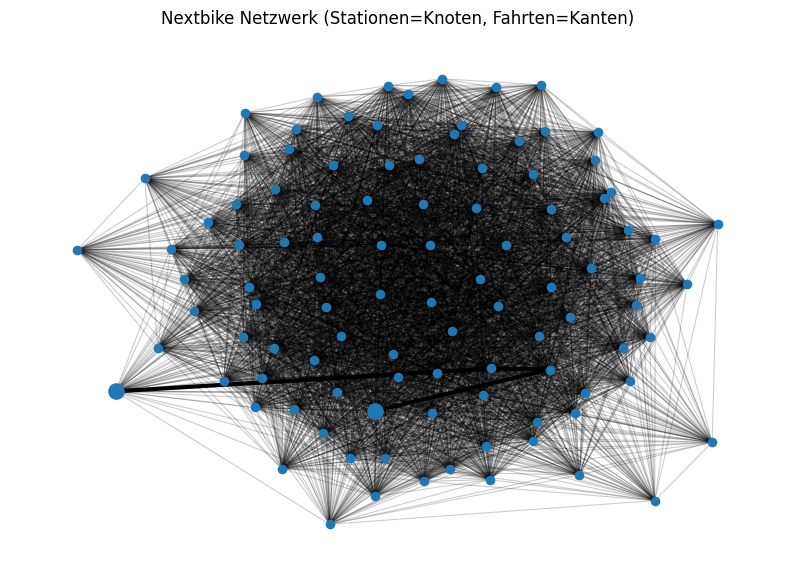

Knoten: 103, Kanten: 4763
Top 5 meistbefahrene Routen:
  Hochschule Mannheim <-> Lindenhofplatz / HBF Süd: 3817 Fahrten
  A5 - Universität West <-> Hauptbahnhof Mannheim: 3696 Fahrten
  Hauptbahnhof Mannheim <-> Universität Schloss: 3497 Fahrten
  Lindenhofplatz / HBF Süd <-> Neckarau - Hans-Sachs-Ring: 2192 Fahrten
  A5 - Universität West <-> Universität Schloss: 2064 Fahrten


In [15]:
import networkx as nx
import matplotlib.pyplot as plt

start_col, end_col = "ausleihstationname", "rueckgabestationname"
missing = [c for c in [start_col, end_col] if c not in df_nextbike.columns]
if missing:
    raise ValueError(f"Fehlende Spalten: {missing}. Verfügbar: {list(df_nextbike.columns)}")

rides = df_nextbike[[start_col, end_col]].dropna().astype(str)
a = rides[[start_col, end_col]].min(axis=1)
b = rides[[start_col, end_col]].max(axis=1)
edge_counts = (
    pd.DataFrame({"source": a, "target": b})
    .query("source != target")
    .value_counts()
    .reset_index(name="fahrten")
)

G = nx.Graph()
for s, t, n in edge_counts.itertuples(index=False):
    G.add_edge(s, t, fahrten=int(n), cost=1 / float(n))

source, target = list(G.nodes)[0], list(G.nodes)[-1]
route = nx.shortest_path(G, source=source, target=target, weight="cost")
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 7))
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.8)
nx.draw_networkx_nodes(G, pos, node_size=35)
nx.draw_networkx_edges(G, pos, edgelist=list(zip(route[:-1], route[1:])), width=3)
nx.draw_networkx_nodes(G, pos, nodelist=[source, target], node_size=120)
plt.title("Nextbike Netzwerk (Stationen=Knoten, Fahrten=Kanten)")
plt.axis("off")
plt.show()

print(f"Knoten: {G.number_of_nodes()}, Kanten: {G.number_of_edges()}")
print("Top 5 meistbefahrene Routen:")
for u, v, d in sorted(G.edges(data=True), key=lambda x: x[2].get("fahrten", 0), reverse=True)[:5]:
    print(f"  {u} <-> {v}: {d['fahrten']} Fahrten")

In [22]:
# --- OSM-Längen für Routen/Kanten (Top 100, ohne Luftlinie) ---
import networkx as nx
import pandas as pd
import osmnx as ox

req = ["ausleihstationname", "rueckgabestationname", "start_lat", "start_lon", "end_lat", "end_lon"]
miss = [c for c in req if c not in df_nextbike.columns]
if miss:
    raise ValueError(f"Fehlende Spalten: {miss}")

rides = df_nextbike[req].dropna().copy()
rides["a"] = rides[["ausleihstationname", "rueckgabestationname"]].min(axis=1)
rides["b"] = rides[["ausleihstationname", "rueckgabestationname"]].max(axis=1)
rides = rides[rides["a"] != rides["b"]]

edge_counts = rides[["a", "b"]].value_counts().reset_index(name="fahrten")
edge_counts = edge_counts.sort_values("fahrten", ascending=False).head(100)

start_xy = rides[["ausleihstationname", "start_lat", "start_lon"]].rename(
    columns={"ausleihstationname": "station", "start_lat": "lat", "start_lon": "lon"}
)
end_xy = rides[["rueckgabestationname", "end_lat", "end_lon"]].rename(
    columns={"rueckgabestationname": "station", "end_lat": "lat", "end_lon": "lon"}
)
station_xy = pd.concat([start_xy, end_xy], ignore_index=True).groupby("station", as_index=False)[["lat", "lon"]].mean()
station_xy = station_xy[station_xy["station"].isin(pd.unique(edge_counts[["a", "b"]].to_numpy().ravel()))]
station_xy = station_xy[
    station_xy["lat"].between(49.35, 49.60) & station_xy["lon"].between(8.35, 8.60)
]
if station_xy.empty:
    raise ValueError("Keine Stationen im Mannheim-Bereich gefunden.")

G_osm = ox.graph_from_place("Mannheim, Germany", network_type="bike", simplify=True)
station_xy["osm_node"] = ox.distance.nearest_nodes(G_osm, X=station_xy["lon"], Y=station_xy["lat"])
node_map = dict(zip(station_xy["station"], station_xy["osm_node"]))

if "G" not in globals():
    G = nx.Graph()

rows = []
for s, t, n in edge_counts.itertuples(index=False):
    if s not in node_map or t not in node_map:
        continue
    length_m = nx.shortest_path_length(G_osm, node_map[s], node_map[t], weight="length")
    G.add_edge(s, t, fahrten=int(n), length_m=float(length_m), cost=float(length_m) / max(int(n), 1))
    rows.append((s, t, int(n), float(length_m)))

edge_lengths = pd.DataFrame(rows, columns=["source", "target", "fahrten", "length_m"]).sort_values("fahrten", ascending=False)
print(f"Längen für {len(edge_lengths)} Routen berechnet und als length_m/cost im Graph gespeichert.")
print(edge_lengths.head())

Längen für 100 Routen berechnet und als length_m/cost im Graph gespeichert.
                     source                      target  fahrten     length_m
0       Hochschule Mannheim    Lindenhofplatz / HBF Süd     3817  1322.902519
1     A5 - Universität West       Hauptbahnhof Mannheim     3696  1468.776953
2     Hauptbahnhof Mannheim         Universität Schloss     3497   957.395398
3  Lindenhofplatz / HBF Süd  Neckarau - Hans-Sachs-Ring     2192  2614.790463
4     A5 - Universität West         Universität Schloss     2064   936.088374


In [ ]:
# --- OSM Way-Tags + Laenge (erste 5 IDs) ---
from OSMPythonTools.api import Api
from OSMPythonTools.element import Element

df_sr = next(iter(cleaned["stadtradeln_2024.xlsx"].values()))
way_ids = df_sr.iloc[:5, 0].dropna().astype(int).tolist()
api = Api()

for wid in way_ids:
    way = api.query(f"way/{wid}")
    tags = way.tags() or {}
    print("\nWay:", wid)
    print("Name:", tags.get("name"))
    print("Highway:", tags.get("highway"))
    print("Surface:", tags.get("surface"))
    print("Maxspeed:", tags.get("maxspeed"))
    print("Oneway:", tags.get("oneway"))
    print("Lit:", tags.get("lit"))
    print("Cycleway:", tags.get("cycleway"))
    print("Access:", tags.get("access"))
    print("Length_m:", length_m)
    print("All tags:", tags)


Way: 27706046
Name: Hallenweg
Highway: unclassified
Surface: asphalt
Maxspeed: 50
Oneway: no
Lit: None
Cycleway: None
Access: None
Length_m: None
All tags: {'bicycle': 'yes', 'highway': 'unclassified', 'maxspeed': '50', 'motor_vehicle': 'yes', 'name': 'Hallenweg', 'oneway': 'no', 'surface': 'asphalt'}

Way: 250767280
Name: None
Highway: footway
Surface: None
Maxspeed: None
Oneway: None
Lit: None
Cycleway: None
Access: None
Length_m: None
All tags: {'highway': 'footway'}

Way: 28924618
Name: Waldblick
Highway: residential
Surface: asphalt
Maxspeed: 30
Oneway: None
Lit: yes
Cycleway: None
Access: None
Length_m: None
All tags: {'highway': 'residential', 'lit': 'yes', 'maxspeed': '30', 'name': 'Waldblick', 'sidewalk': 'both', 'smoothness': 'good', 'source:maxspeed': 'DE:zone30', 'surface': 'asphalt'}

Way: 250767010
Name: Martinistraße
Highway: residential
Surface: asphalt
Maxspeed: 30
Oneway: no
Lit: yes
Cycleway: None
Access: None
Length_m: None
All tags: {'highway': 'residential', 'lcn